In [157]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from tensorflow import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers import LSTM ,Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from keras.regularizers import L1L2
from tensorflow.keras.models import load_model
from numpy.random import seed



class LSTM_Model():
    seed(42)
    tf.random.set_seed(42)  
    def __init__(self, dataframe, window_size, lags, trainsize):

        self.dataframe = dataframe
        self.window_size = window_size
        self.lags = lags
        self.trainsize = trainsize

    # moving average calculation
    def moving_average(self):
        
        
        i = 0
        moving_averages = []
        while i < len(self.dataframe['Total']) - self.window_size + 1:
            this_window = self.dataframe['Total'][i : i + self.window_size]
            window_average = sum(this_window) / self.window_size
            moving_averages.append(window_average)
            i += 1
        sales = pd.DataFrame(moving_averages, columns=['Total'])
        # sales_norm = scaler.fit_transform(sales.Total.values.reshape(-1, 1))
        # sales['sales_norm'] = sales_norm
        # sales = sales.drop(['Total'],axis = 1)
        return sales

    def scaled(self):
        scaler = MinMaxScaler()
        sales = self.moving_average()
        sales_norm = scaler.fit_transform(sales.Total.values.reshape(-1, 1))
        sales['sales_norm'] = sales_norm
        sales = sales.drop(['Total'],axis = 1)
        return sales

    #adding lag to the sales for multistep forecasting
    def lags_cal(self):

        sales = self.scaled()
        for lag in range(1,self.lags):
            col_name = 'lag_' +str(lag)
            sales[col_name] = sales['sales_norm'].shift(lag)
        #drop null val
        sales = sales.dropna().reset_index(drop = True)
        return sales

    # tain and test dataset
    def split_train_test(self):

        """ This function splits the dataframe in to train and test sets and converts in to LSTM readable format
        It needs 2 input: 
            1. Dataframe to split the dta into train and test
            2. trainsize in percentage ratio.
                eg: if you want 80% of the data as training then plug in 0.8"""

        sales = self.lags_cal()
        train = sales[: int(len(sales)*self.trainsize)].values
        test =  sales[int(len(sales)*self.trainsize):].values
        X_train = train[:, 1:]
        y_train = train[:, 0:1]
        X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
        X_test = test[:, 1:]
        y_test = test[:, 0:1]
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        return X_train, y_train, X_test, y_test

    def build_LSTM(self):

        X_train, y_train, X_test, y_test = self.split_train_test()
        K.clear_session()
        model = Sequential()
        model.add(Bidirectional(LSTM(64, activation = 'tanh', 
                                input_shape = ( X_train.shape[1], X_train.shape[2]), 
                                return_sequences=True)))
        model.add(Bidirectional(LSTM(32, activation = 'tanh', 
                                return_sequences = False)))
        model.add(Dropout(0.5))
        model.add(Dense(50, activation = 'tanh'))
        model.add(Dense(y_train.shape[1]))

        return model

    # fit the model
    def fit_evaluate_model(self):
        
        """ This function prints all the epochs, loss and val score plot and also
        evaluation score on test data and return the fitmodel as 'mod', 
        which also can be used in to function (evaluate_model)"""

        X_train, y_train, X_test, y_test = self.split_train_test()
        mod = self.build_LSTM()
        mod.compile(optimizer='adam', loss='mse')
        cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                    min_delta=0.01,
                                    patience=100,
                                    verbose=1,
                                    mode="min",
                                    baseline=None,
                                    restore_best_weights=False)
        history = mod.fit(X_train,y_train, 
                    epochs = 500, 
                    batch_size = 8, 
                    validation_split=0.2, 
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= True)
        pd.DataFrame(history.history).plot()
        plt.grid(True)
        plt.gca() # set the y range to [0,1]
        plt.show()
        print('\n')
        print('*****************************************')
        print('\n')
        print('Model Evalution Score')
        print(mod.evaluate(X_test, y_test)) 
        return mod
        
    # model evaluation
    def evaluate_model(self,mod):

        X_train, y_train, X_test, y_test = self.split_train_test()
        print(mod.evaluate(X_test, y_test)) 
        
    """ How to run:
    sales_pred = LSTM_Model(sales_, 4, 6, 0.9)
    model = sales_pred.fit_evaluate_model()

    the below code is not necessary: 
    
    sales_pred.evaluate_model(model)   """

In [158]:
sales_tot = pd.read_csv('./data/sales_full.csv', index_col=0)
#sales_tot.head()
sales_tot = sales_tot.drop(['year','week','weeks'], axis = 1)
sales_ = sales_tot.copy()

Epoch 1/500
12/12 [==============================] - 8s 128ms/step - loss: 0.1156 - val_loss: 0.0583
Epoch 2/500
12/12 [==============================] - 0s 16ms/step - loss: 0.0388 - val_loss: 0.0093
Epoch 3/500
12/12 [==============================] - 0s 14ms/step - loss: 0.0363 - val_loss: 0.0085
Epoch 4/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0247 - val_loss: 0.0120
Epoch 5/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0226 - val_loss: 0.0077
Epoch 6/500
12/12 [==============================] - 0s 13ms/step - loss: 0.0192 - val_loss: 0.0074
Epoch 7/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0202 - val_loss: 0.0067
Epoch 8/500
12/12 [==============================] - 0s 12ms/step - loss: 0.0147 - val_loss: 0.0066
Epoch 9/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0123 - val_loss: 0.0044
Epoch 10/500
12/12 [==============================] - 0s 11ms/step - loss: 0.0120 - val_loss: 0.004

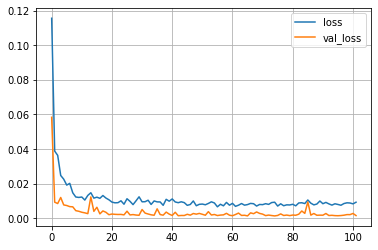



*****************************************


Model Evalution Score
1/1 [==============================] - 1s 1s/step - loss: 0.0041
0.004059961996972561


In [159]:
sales_pred = LSTM_Model(sales_, 4, 6, 0.9)
history = sales_pred.fit_evaluate_model()

In [160]:
sales_pred.evaluate_model(history)

1/1 [==============================] - 0s 21ms/step - loss: 0.0041
0.004059961996972561


In [163]:
# moving average calculation
def moving_average(dataframe, window_size):
    
    window_size = 4
    #tot = sales['Total].tolist()
    i = 0
    moving_averages = []
    while i < len(dataframe['Total']) - window_size + 1:
        this_window = dataframe['Total'][i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    sales = pd.DataFrame(moving_averages, columns=['Total'])
    return sales

#adding lag to the sales for multistep forecasting
def lags(dataframe, lags):
    for lag in range(1,lags):
        col_name = 'lag_' +str(lag)
        dataframe[col_name] = dataframe['sales_norm'].shift(lag)
    #drop null val
    dataframe = dataframe.dropna().reset_index(drop = True)
    return dataframe


def forecasting(dataframe, window_size, lag, n_future):
    
    #dataframe = sales_
    #window_size = 4
    #lags = 6
    #n_future = number of weeks /days to forecast in future

    model = load_model(r'.\models\model_final.h5') 
    scaler = MinMaxScaler()
    for n in range(n_future):
    
        sales = pd.DataFrame(moving_average(dataframe, window_size), columns=['Total'])
        sales_norm = scaler.fit_transform(sales.Total.values.reshape(-1, 1))
        sales_norm = sales_norm.flatten().tolist()
        sales['sales_norm'] = sales_norm
        sales = sales.drop(['Total'],axis = 1)
        sales = lags(sales,lag)
        last_row = sales[-1:]
        last_row = last_row.drop(['sales_norm'], axis = 1)
        last_row = last_row.to_numpy()
        last_row = last_row.reshape(last_row.shape[0], 1, last_row.shape[1])
        pred = model.predict(last_row)
        forecast = scaler.inverse_transform(pred)[:,0]#.tolist()
        forecast = pd.DataFrame(forecast, columns = ['Total'])
        dataframe = pd.concat([dataframe, forecast], ignore_index=True)
    print(dataframe)

In [164]:
forecasting(sales_, 4,6, 20)

            Total
0    37640.000000
1    19520.000000
2     1270.000000
3     2700.000000
4     3560.000000
..            ...
154  47352.722656
155  47270.066406
156  47550.515625
157  47840.859375
158  48008.507812

[159 rows x 1 columns]
